In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [256]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import statistics
import xgboost as xgb
#Scikit-learn modules
from sklearn.tree  import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
# %cd /content/drive/MyDrive/Colab\ Notebooks/CarPricePrediction
seed = 42

In [ ]:
# Hypothesis: Important model features are represented in the Name column and if they are similar they can be in the same category.
def editDistance(str1, str2, m, n):
    if m == 0:
        return n
    if n == 0:
        return m
    if str1[m-1] == str2[n-1]:
        return editDistance(str1, str2, m-1, n-1)
    return 1 + min(
            editDistance(str1, str2, m, n-1),
            editDistance(str1, str2, m-1, n),
            editDistance(str1, str2, m-1, n-1)
            )

# Autos Data Preprocess

In [248]:
def preprocess_autos(freq_encoding=True):
    data = pd.read_csv('Data/autos.csv', index_col='index')
    data = data.loc[(data['price'] > 0) & (data['price'] < 35000)]
    
    # datetime to timestamp
    data['createdTimestamp'] = data['dateCreated'].apply(lambda t: time.mktime(datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S").timetuple())).astype(int)
    data['createdTimestamp'] = data['createdTimestamp'] - data['createdTimestamp'].min()
    
    # age
    data['age'] = 2016 - data['yearOfRegistration']
    data['age'] = data['age'].apply(lambda age: np.nan if age < 0 or age > 80 else age)
    
    # model
    data['model'] = data['model'].apply(lambda x: str(x).lower() if not x is np.nan else np.nan)
    
    # power
    data['powerPS'] = data['powerPS'].apply(lambda p: p if p > 70 and p < 400 else np.nan)
    
    # gearbox
    data['gearbox'] = (data['gearbox'] == 'automatik').astype(int)

    # damage
    data['notRepairedDamage'] = data['notRepairedDamage'].apply(lambda x: int(x == 'nein') if not x is np.nan else np.nan)
    
    # seller
    data['seller'] = (data['seller'] == 'privat').astype(int)
    
    # offer type
    data['offerType'] = (data['offerType'] == 'Angebot').astype(int)
    
    # vehicle type
    data['vehicleType'] = data['vehicleType'].astype('category')
    data['model'] = data['model'].astype('category')
    data['fuelType'] = data['fuelType'].astype('category')
    data['brand'] = data['brand'].astype('category')
    
    if freq_encoding:
        enc = (data.groupby('vehicleType').size()) / len(data)
        data['vehicleType'] = data['vehicleType'].apply(lambda x: enc[x])
        
        enc = (data.groupby('model').size()) / len(data)
        data['model'] = data['model'].apply(lambda x: enc[x])
        
        enc = (data.groupby('fuelType').size()) / len(data)
        data['fuelType'] = data['fuelType'].apply(lambda x: enc[x])
        
        enc = (data.groupby('brand').size()) / len(data)
        data['brand'] = data['brand'].apply(lambda x: enc[x])
    
    
    data.drop(columns=['dateCrawled', 'yearOfRegistration', 'monthOfRegistration', 'abtest', 'nrOfPictures', 'name', 'lastSeen', 'dateCreated', 'postalCode'], inplace=True)
    
    return data

In [249]:
data = preprocess_autos()

In [250]:
data.head()

,seller,offerType,price,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,createdTimestamp,age
index,,,,,,,,,,,,,
0,1,1,480,NaN,0,NaN,0.081444,150000,0.605555,0.215018,NaN,64368000,23.0
1,1,1,18300,0.048809,0,190.0,NaN,125000,0.293384,0.087652,0.0,64368000,5.0
2,1,1,9800,0.038870,1,163.0,0.001640,125000,0.293384,0.002111,NaN,63504000,12.0
3,1,1,1500,0.219243,0,75.0,0.081444,150000,0.605555,0.215018,1.0,63763200,15.0
4,1,1,3600,0.219243,0,NaN,0.005776,90000,0.293384,0.015614,1.0,64969200,8.0


In [258]:
imp = SimpleImputer(strategy="most_frequent")
imp.fit_transform(data)

array([[1.00000e+00, 1.00000e+00, 4.80000e+02, ..., 1.00000e+00,
        6.43680e+07, 2.30000e+01],
       [1.00000e+00, 1.00000e+00, 1.83000e+04, ..., 0.00000e+00,
        6.43680e+07, 5.00000e+00],
       [1.00000e+00, 1.00000e+00, 9.80000e+03, ..., 1.00000e+00,
        6.35040e+07, 1.20000e+01],
       ...,
       [1.00000e+00, 1.00000e+00, 9.20000e+03, ..., 1.00000e+00,
        6.39360e+07, 2.00000e+01],
       [1.00000e+00, 1.00000e+00, 3.40000e+03, ..., 1.00000e+00,
        6.40224e+07, 1.40000e+01],
       [1.00000e+00, 1.00000e+00, 2.89900e+04, ..., 1.00000e+00,
        6.28992e+07, 3.00000e+00]])

In [260]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(data)

IterativeImputer(random_state=0)

In [264]:
imp_data = pd.DataFrame(imp.transform(data), columns=data.columns)

In [187]:
for col in data.columns:
    print(col, data[col].unique())

seller ['privat' 'gewerblich']
offerType ['Angebot' 'Gesuch']
price [  480 18300  9800 ... 18429 24895 10985]
vehicleType [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi'
 'andere']
gearbox ['manuell' 'automatik' nan]
powerPS [ nan 190. 163.  75. 102. 109. 125. 101. 105. 140. 115. 131. 136. 160.
 231.  90. 118. 193.  99. 113. 218. 122. 129. 306.  95. 177.  80. 170.
 143. 286. 232. 150. 156.  82. 204. 155. 185.  87. 180.  86.  84. 303.
 224. 235. 200. 178. 265.  77. 110. 144. 120. 116. 184. 126.  88. 194.
 305. 197. 179. 250. 313. 165.  98. 130. 114. 211. 326. 201. 213. 107.
  83. 174. 100. 220.  85.  73. 192. 299.  74. 147. 310.  71.  97. 239.
 295. 203. 300. 103. 245. 258. 292. 320.  81. 148. 354. 145. 280. 260.
 104. 188. 333. 186. 117. 141. 132. 234. 158. 272.  92. 135. 230. 209.
 146. 106. 166. 276. 344. 349.  72. 249. 237. 111. 279. 138. 256. 175.
  96. 226. 301. 334. 128. 133. 124. 219. 241. 167.  94. 182. 196. 238.
 277. 228. 112. 139.  79. 360. 243. 252. 396. 

In [123]:
def name2features(row):
    #print(row)
    name = str(row['name']).lower().split('_')
    #print(name)
    if str(row['brand']).lower() in name:
        name.remove(row['brand'].lower())
    if str(row['model']).lower() in name:
        name.remove(row['model'].lower())
    return name
        
# data.apply(name2features, axis=1)
# Did not use it but it could be used

Text(0, 0.5, 'Number of Cars')

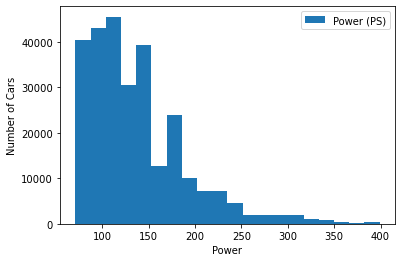

In [88]:
plt.hist(data['powerPS'], bins=20, label='Power (PS)')
plt.legend()
plt.xlabel('Power')
plt.ylabel('Number of Cars')
# plt.savefig('Power.png')

# Preprocessing

In [156]:
train = pd.read_csv("Data/train-data.csv")
test = pd.read_csv("Data/train-data.csv")

In [157]:
df = pd.concat([train, test], ignore_index=True)

In [158]:
df.isna().sum()

Unnamed: 0               0
Name                     0
Location                 0
Year                     0
Kilometers_Driven        0
Fuel_Type                0
Transmission             0
Owner_Type               0
Mileage                  4
Engine                  72
Power                   72
Seats                   84
New_Price            10390
Price                    0
dtype: int64

In [6]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [7]:
location_dict = {
        'Mumbai':(19.07, 72.87),
        'Pune':(18.52, 73.85),
        'Chennai':(13.08, 80.27),
        'Coimbatore':(11.01, 76.95),
        'Hyderabad': (17.38, 78.48),
        'Jaipur':(26.91, 75.78),
        'Kochi':(9.93, 76.26),
        'Kolkata':(22.57, 88.36),
        'Delhi':(28.70, 77.10),
        'Bangalore':(12.97, 77.59),
        'Ahmedabad':(23.02, 72.57)
        }

def preprocess(x):
    cc_str = str(x["Engine"])[:-3]
    if cc_str != "":
        x["Engine"] = int(cc_str)
    # 0 is out of domain
    # 0 will change with median
    
    tmp = x["Name"].split()
    x["Brand"] = tmp[0]
    x["Model"] = tmp[1]
    
    tmp = location_dict[x["Location"]]
    x["Longitude"] = tmp[0]
    x["Latitude"] = tmp[1]
    
    if x["Power"] != "" and x["Power"] != "null bhp":
        power_str = str(x["Power"]).split()[0]
        x["Power"] = float(power_str)
    else: x["Power"] = 0
    
    if x["Mileage"] != "":
        power_str = str(x["Mileage"]).split()[0]
        x["Mileage"] = float(power_str)
    else: x["Mileage"] = 0
    
    x["Age"] = 2019 - x["Year"]
    
    if x["Owner_Type"] == "First":
        x["Owner_Type"] = 1
    elif x["Owner_Type"] == "Second":
        x["Owner_Type"] = 2
    elif x["Owner_Type"] == "Third":
        x["Owner_Type"] = 3
    elif x["Owner_Type"] == "Fourth & Above":
        x["Owner_Type"] = 4
        
    if x["Fuel_Type"] == "CNG" or x["Fuel_Type"] == "LPG":
        x["Fuel_Type"] = "Gas"
    return x

In [8]:
df = df.apply(preprocess, axis=1)
df.drop(columns=["Name", "Location", "Unnamed: 0", "Year", "New_Price"], inplace=True)

In [9]:
df

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Longitude,Latitude,Age
0,72000,Gas,Manual,1,26.60,998.0,58.16,5.0,1.75,Maruti,Wagon,19.07,72.87,9
1,41000,Diesel,Manual,1,19.67,1582.0,126.20,5.0,12.50,Hyundai,Creta,18.52,73.85,4
2,46000,Petrol,Manual,1,18.20,1199.0,88.70,5.0,4.50,Honda,Jazz,13.08,80.27,8
3,87000,Diesel,Manual,1,20.77,1248.0,88.76,7.0,6.00,Maruti,Ertiga,13.08,80.27,7
4,40670,Diesel,Automatic,2,15.20,1968.0,140.80,5.0,17.74,Audi,A4,11.01,76.95,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12033,27365,Diesel,Manual,1,28.40,1248.0,74.00,5.0,4.75,Maruti,Swift,28.70,77.10,5
12034,100000,Diesel,Manual,1,24.40,1120.0,71.00,5.0,4.00,Hyundai,Xcent,26.91,75.78,4
12035,55000,Diesel,Manual,2,14.00,2498.0,112.00,8.0,2.90,Mahindra,Xylo,26.91,75.78,7
12036,46000,Petrol,Manual,1,18.90,998.0,67.10,5.0,2.65,Maruti,Wagon,22.57,88.36,6


In [10]:
df.drop(df[df["Kilometers_Driven"] == df["Kilometers_Driven"].max()].index, inplace=True)
df.drop(df[df["Fuel_Type"] == "Electric"].index, inplace=True)

In [4]:
return
def fill_median(x):
    # na is replaced with 0 previously
    if x["Power"] == 0:
        x["Power"] = train["Power"].median()

    if x["Mileage"] == 0:
        x["Mileage"] = train["Mileage"].median()
    
    return x
train = train.apply(fill_median, axis=1)

NameError: ignored

In [11]:
df["Brand"] = df["Brand"].astype("category")
df["Model"] = df["Model"].astype("category")
df["Fuel_Type"] = df["Fuel_Type"].astype("category")
df["Transmission"] = df["Transmission"].astype("category")

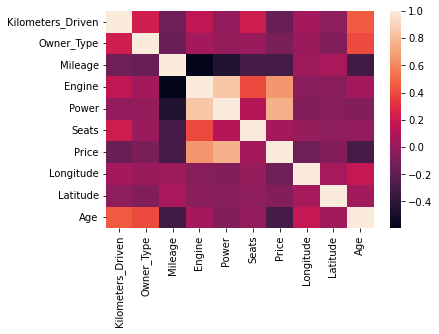

In [14]:
figure = sns.heatmap(df.corr())
# Power and engine has a great correlation can be used together
# Curse of dimensionality can be avoided

In [12]:
df.to_pickle("Data/preprocessed_dataframe.pkl")

# Save

In [159]:
df = pd.read_pickle("Data/preprocessed_dataframe.pkl")

In [160]:
scaler = StandardScaler()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns
numeric_columns = np.delete(numeric_columns, np.argwhere(numeric_columns == "Price"))
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [161]:
df.head()

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Longitude,Latitude,Age
0,0.378244,Gas,Manual,-0.444686,1.847294,-1.037315,-0.957299,-0.344737,1.75,Maruti,Wagon,0.182624,-1.084610,1.026889
1,-0.440100,Diesel,Manual,-0.444686,0.334922,-0.065368,0.270238,-0.344737,12.50,Hyundai,Creta,0.089273,-0.844843,-0.502336
2,-0.308109,Petrol,Manual,-0.444686,0.014115,-0.702792,-0.406314,-0.344737,4.50,Honda,Jazz,-0.834060,0.725875,0.721044
3,0.774217,Diesel,Manual,-0.444686,0.574981,-0.621241,-0.405232,2.127601,6.00,Maruti,Ertiga,-0.834060,0.725875,0.415199
4,-0.448811,Diesel,Automatic,1.746332,-0.640591,0.577049,0.533643,-0.344737,17.74,Audi,A4,-1.185402,-0.086397,0.109354


In [168]:
df = df[df['Price'] < 65]

In [54]:
# df["Mileage"] = df["Mileage"].fillna(df["Mileage"].median())

In [169]:
df.isna().sum()

Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               0
Engine               72
Power                72
Seats                84
Price                 0
Brand                 0
Model                 0
Longitude             0
Latitude              0
Age                   0
dtype: int64

In [170]:
imputer = KNNImputer(n_neighbors=10)
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
df.isna().sum()

Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Brand                0
Model                0
Longitude            0
Latitude             0
Age                  0
dtype: int64

# Decision Tree & Random Forest

In [49]:
df_encoded = df.copy()

trans_le = LabelEncoder()
df_encoded["Transmission"] = trans_le.fit_transform(df["Transmission"]).astype(int)

ft_le = LabelEncoder()
df_encoded["Fuel_Type"] = ft_le.fit_transform(df["Fuel_Type"]).astype(int)

brand_le = LabelEncoder()
df_encoded["Brand"] = brand_le.fit_transform(df["Brand"]).astype(int)

model_le = LabelEncoder()
df_encoded["Model"] = model_le.fit_transform(df["Model"]).astype(int)

In [63]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit_transform(df["Transmission"])

ValueError: Expected 2D array, got 1D array instead:
array=['Manual' 'Manual' 'Manual' ... 'Manual' 'Manual' 'Manual'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [41]:
X, y = df_encoded.drop(columns="Price"), df_encoded["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

## Decision Tree

In [42]:
dt = DecisionTreeRegressor(min_samples_leaf=50, random_state=42)

In [43]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=50, random_state=42)

In [44]:
dt.score(X_test, y_test)

0.8490631513087468

In [45]:
y_pred = dt.predict(X_test)

In [50]:
df_encoded.loc[1562]

Kilometers_Driven     -0.968064
Fuel_Type              0.000000
Transmission           0.000000
Owner_Type            -0.444686
Mileage               -1.323669
Engine                 2.239677
Power                  2.348607
Seats                  2.127601
Price                 48.000000
Brand                  1.000000
Model                135.000000
Longitude             -0.852731
Latitude               0.070186
Age                   -0.502336
Name: 1562, dtype: float64

In [31]:
y_pred - y_test

4413      0.477361
10479     1.263151
5035     -0.383140
2612      4.435977
1562     16.011000
           ...    
5611      0.444674
1765     -0.055625
5499     -0.933140
2457      0.076296
5668      0.738627
Name: Price, Length: 3610, dtype: float64

In [28]:
mean_squared_error(y_pred, y_test)

19.886181367604586

## Random Forest

In [ ]:
reg = RandomForestRegressor(max_depth=30, random_state=42)
reg.fit(X_train, y_train)
y_pred = clf.predict(X_test)
reg.score(X_test, y_test)

0.0455446484498858

In [ ]:
mean_squared_error(y_pred, y_test)

0.0455446484498858

In [ ]:
rf_scores = dict()
for i in range(1, 40):
    clf = RandomForestClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_binned_train)
    rf_scores[i] = clf.score(X_test, y_binned_test)

Text(0, 0.5, 'Classification Score')

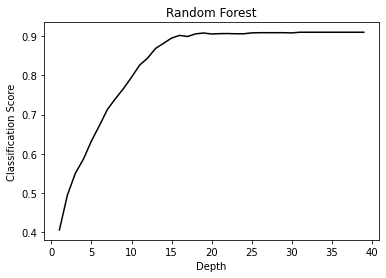

In [ ]:
plt.plot(rf_scores.keys(), rf_scores.values(), color="black")
plt.title("Random Forest")
plt.xlabel("Depth")
plt.ylabel("Classification Score")

# XGBOOST

In [39]:
! pip install -U xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [179]:
def xgboost(df):
    X, y = df.drop(columns=['Price']), df['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    xgbr = xgb.XGBRegressor(enable_categorical=True, tree_method="gpu_hist", verbosity=0, random_state=seed)
    xgbr.fit(X_train, y_train)
    
    # test
    score = xgbr.score(X_test, y_test)
    print(score)
    y_pred = xgbr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(mse)
    return xgbr

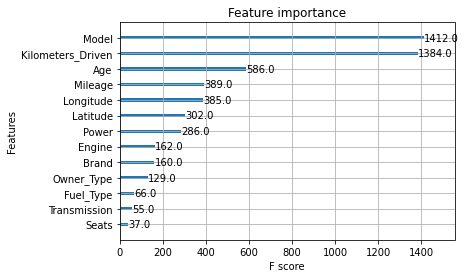

In [22]:
xgbr = xgboost(df)
xgb.plot_importance(xgbr)

# XGBOOST with PCA

In [ ]:
mse = dict()
score = dict()
for n in range(1, 13):
    pca = PCA(n_components = n)
    pca.fit(X)

    X_pca = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = 42, shuffle = True)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    xgbr = xgb.XGBRegressor(verbosity=0) 
    xgbr.fit(X_train, y_train)
    score[n] = xgbr.score(X_test, y_test)
    y_pred = xgbr.predict(X_test)
    mse[n] = mean_squared_error(y_test, y_pred)
    

Text(0.5, 1.0, 'PCA')

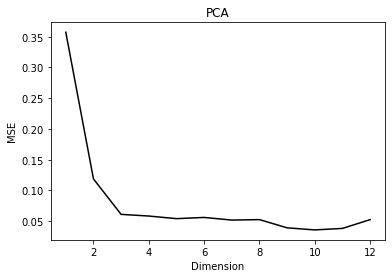

In [ ]:
plt.plot(mse.keys(), mse.values(), color="black")
plt.xlabel("Dimension")
plt.ylabel("MSE")
plt.title("PCA")